Epoch 1/100


C:\Users\Shenanigans\AppData\Local\Temp\ipykernel_126856\2228218226.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.dropna(inplace=True)
C:\Users\Shenanigans\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


247/247 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - loss: 1.3248 - val_loss: 0.1547
Epoch 2/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - loss: 0.2585 - val_loss: 0.1350
Epoch 3/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - loss: 0.1917 - val_loss: 0.1280
Epoch 4/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - loss: 0.1794 - val_loss: 0.1257
Epoch 5/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - loss: 0.1674 - val_loss: 0.1250
Epoch 6/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - loss: 0.1606 - val_loss: 0.1266
Epoch 7/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - loss: 0.1556 - val_loss: 0.1255
Epoch 8/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - loss: 0.1541 - val_loss: 0.1257
Epoch 9/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - loss: 0.1526 - val_loss: 0.1288
Epoch 10/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - loss: 0.1521 - val_loss: 0.1264
Epoch 11/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - loss: 0.1504 - val_loss: 0.1282
Epoch 12/100
247/247 ━━━━━━━━━━

Model saved to lstm_autoencoder_model_tuned.h5


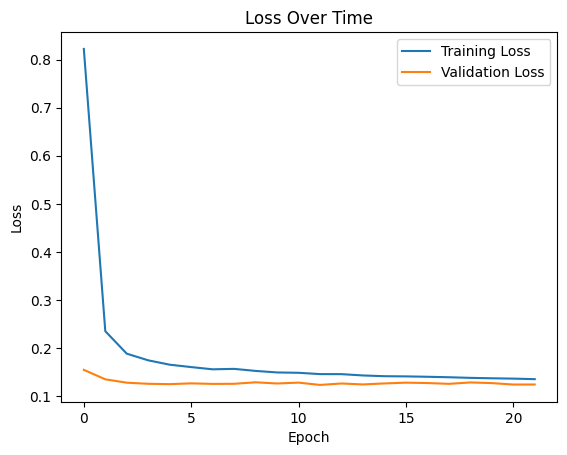

154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Silhouette Score: 0.9321


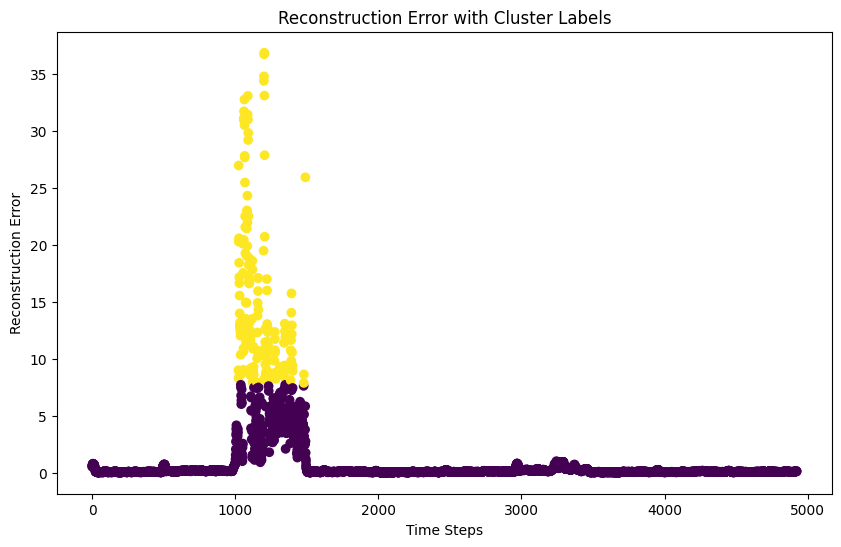

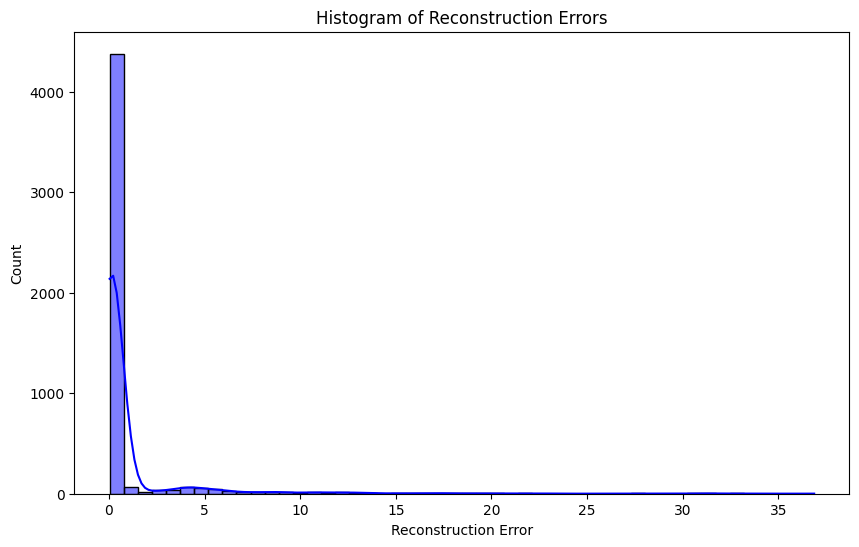

Cluster 0 Mean Squared Error: 0.4475
Cluster 1 Mean Squared Error: 15.2157


In [21]:
# Import necessary libraries
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = 'clean_merged.csv'
clean_merged_df = pd.read_csv(file_path)

# Select features for anomaly detection
features = clean_merged_df[['Market Price', 'PE Ratio', 'PB Ratio', 'ROE', 'Volume', 'sentiment_score']]

# Remove rows with missing values
features.dropna(inplace=True)

# Scale the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Use the scaled features directly
features_processed = features_scaled

# Reshape the data to [samples, timesteps, features] for LSTM
timesteps = 30  # You can experiment with different timesteps
X = []
for i in range(timesteps, len(features_processed)):
    X.append(features_processed[i - timesteps:i])
X = np.array(X)

# Split into training and test sets (80% training, 20% testing)
split_ratio = 0.8
split_index = int(split_ratio * X.shape[0])

X_train = X[:split_index]
X_test = X[split_index:]

# Build the LSTM Autoencoder model with Dropout layers to prevent overfitting
def create_model(timesteps, features):
    model = Sequential()
    
    # Encoder
    model.add(LSTM(128, activation='relu', input_shape=(timesteps, features), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64, activation='relu', return_sequences=False))
    model.add(Dropout(0.2))
    model.add(RepeatVector(timesteps))
    
    # Decoder
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(128, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(features)))
    
    # Compile model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Create and compile the model
model = create_model(timesteps, X.shape[2])

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, X_train, 
                    epochs=100,
                    batch_size=64, 
                    validation_split=0.2, 
                    callbacks=[early_stopping],
                    verbose=1)

# Save the trained model
model_file_path = 'lstm_autoencoder_model_tuned.h5'
model.save(model_file_path)
print(f"Model saved to {model_file_path}")

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Time')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Use the trained model to predict on the test set
X_test_pred = model.predict(X_test)

# Calculate reconstruction error
mse_test = np.mean(np.power(X_test - X_test_pred, 2), axis=(1, 2))

# Reshape reconstruction errors
mse_test_reshaped = mse_test.reshape(-1, 1)

# Perform KMeans clustering on reconstruction errors
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(mse_test_reshaped)

# Get cluster labels
cluster_labels = kmeans.labels_

# Compute silhouette score
silhouette_avg = silhouette_score(mse_test_reshaped, cluster_labels)
print(f"Silhouette Score: {silhouette_avg:.4f}")

# Plot the reconstruction error with cluster labels
plt.figure(figsize=(10, 6))
plt.scatter(range(len(mse_test)), mse_test, c=cluster_labels, cmap='viridis')
plt.title('Reconstruction Error with Cluster Labels')
plt.ylabel('Reconstruction Error')
plt.xlabel('Time Steps')
plt.show()

# Plot a histogram of reconstruction errors
plt.figure(figsize=(10, 6))
sns.histplot(mse_test, bins=50, kde=True, color='blue')
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Reconstruction Error')
plt.ylabel('Count')
plt.show()

# Calculate mean squared error for each cluster
cluster_0_mse = mse_test[cluster_labels == 0]
cluster_1_mse = mse_test[cluster_labels == 1]

print(f"Cluster 0 Mean Squared Error: {np.mean(cluster_0_mse):.4f}")
print(f"Cluster 1 Mean Squared Error: {np.mean(cluster_1_mse):.4f}")

C:\Users\Shenanigans\AppData\Local\Temp\ipykernel_126856\2190682842.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.dropna(inplace=True)


Model loaded from lstm_autoencoder_model_tuned.h5
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Silhouette Score: 0.9321
Percentage of anomalies detected: 3.43%


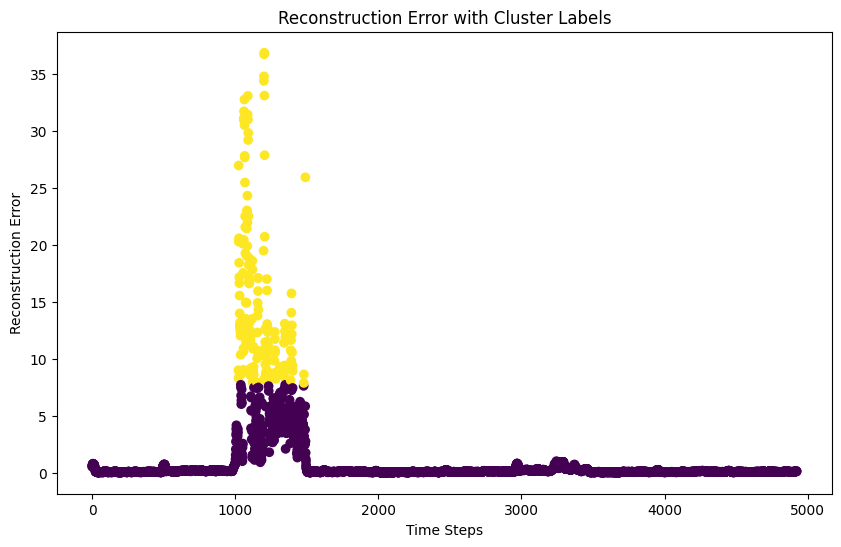

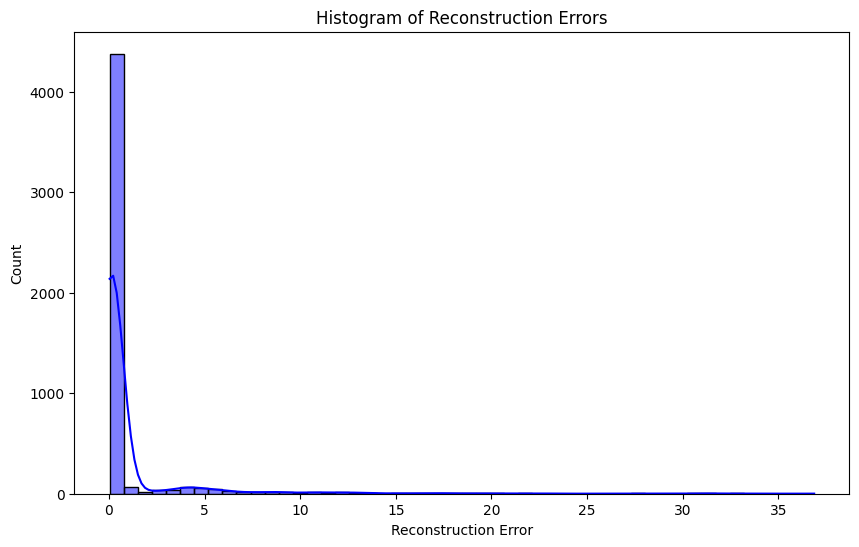

Mean Squared Error for Normal Data: 0.4475
Mean Squared Error for Anomalies: 15.2157
Cluster 0 Mean Squared Error: 0.4475
Cluster 1 Mean Squared Error: 15.2157


InvalidParameterError: The 'y_true' parameter of precision_score must be an array-like or a sparse matrix. Got Ellipsis instead.

In [26]:
# Import necessary libraries
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = 'clean_merged.csv'
clean_merged_df = pd.read_csv(file_path)

# Select features for anomaly detection
features = clean_merged_df[['Market Price', 'PE Ratio', 'PB Ratio', 'ROE', 'Volume', 'sentiment_score']]

# Remove rows with missing values
features.dropna(inplace=True)

# Scale the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Use the scaled features directly
features_processed = features_scaled

# Reshape the data to [samples, timesteps, features] for LSTM
timesteps = 30  # You can experiment with different timesteps
X = []
for i in range(timesteps, len(features_processed)):
    X.append(features_processed[i - timesteps:i])
X = np.array(X)

# Split into training and test sets (80% training, 20% testing)
split_ratio = 0.8
split_index = int(split_ratio * X.shape[0])

X_train = X[:split_index]
X_test = X[split_index:]

# Load the trained model
model_file_path = 'lstm_autoencoder_model_tuned.h5'
model = load_model(model_file_path)
print(f"Model loaded from {model_file_path}")

# Use the trained model to predict on the test set
X_test_pred = model.predict(X_test)

# Calculate reconstruction error
mse_test = np.mean(np.power(X_test - X_test_pred, 2), axis=(1, 2))

# Reshape reconstruction errors
mse_test_reshaped = mse_test.reshape(-1, 1)

# Perform KMeans clustering on reconstruction errors
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(mse_test_reshaped)

# Get cluster labels
cluster_labels = kmeans.labels_

# Compute silhouette score
silhouette_avg = silhouette_score(mse_test_reshaped, cluster_labels)
print(f"Silhouette Score: {silhouette_avg:.4f}")

# Determine which cluster is the anomaly cluster based on higher MSE
cluster_0_mse = mse_test[cluster_labels == 0]
cluster_1_mse = mse_test[cluster_labels == 1]

if np.mean(cluster_0_mse) > np.mean(cluster_1_mse):
    anomaly_cluster = 0
else:
    anomaly_cluster = 1

# Calculate percentage of anomalies detected
anomalies = (cluster_labels == anomaly_cluster)
percentage_anomalies = np.mean(anomalies) * 100
print(f"Percentage of anomalies detected: {percentage_anomalies:.2f}%")

# Plot the reconstruction error with cluster labels
plt.figure(figsize=(10, 6))
plt.scatter(range(len(mse_test)), mse_test, c=cluster_labels, cmap='viridis')
plt.title('Reconstruction Error with Cluster Labels')
plt.ylabel('Reconstruction Error')
plt.xlabel('Time Steps')
plt.show()

# Plot a histogram of reconstruction errors
plt.figure(figsize=(10, 6))
sns.histplot(mse_test, bins=50, kde=True, color='blue')
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Reconstruction Error')
plt.ylabel('Count')
plt.show()

# Evaluation Metric: Mean Squared Error (MSE) between Anomalies and Non-Anomalies
mse_normal = np.mean(mse_test[cluster_labels != anomaly_cluster])
mse_anomalous = np.mean(mse_test[cluster_labels == anomaly_cluster])

print(f"Mean Squared Error for Normal Data: {mse_normal:.4f}")
print(f"Mean Squared Error for Anomalies: {mse_anomalous:.4f}")

# Print cluster statistics
print(f"Cluster 0 Mean Squared Error: {np.mean(cluster_0_mse):.4f}")
print(f"Cluster 1 Mean Squared Error: {np.mean(cluster_1_mse):.4f}")

# Optional Metrics: Precision, Recall, F1-score, and Confusion Matrix (if ground truth labels are available)

# Replace 'true_labels' with actual ground truth values (1 for anomaly, 0 for normal)
# Assuming 'true_labels' contains the ground truth for anomalies (1 for anomaly, 0 for normal)
true_labels = ...  # Replace this with your actual ground truth labels

# Precision, Recall, and F1-score
precision = precision_score(true_labels, anomalies)
recall = recall_score(true_labels, anomalies)
f1 = f1_score(true_labels, anomalies)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(true_labels, anomalies)
print("Confusion Matrix:")
print(cm)

# Optional AUC and ROC Curve
fpr, tpr, thresholds = roc_curve(true_labels, mse_test)
auc_score = roc_auc_score(true_labels, mse_test)

print(f"AUC Score: {auc_score:.4f}")

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.4f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()